In [40]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt

In [43]:
file = './data/trajets_train.csv'
df = pd.read_csv(file,sep=",",index_col=[0]) 
traj1 = df[df['traj']==7809] #3500
print(traj1.shape)
traj2 = df[df['traj']==89117] #2500

traj1 = df[df['traj']==236654]

(3487, 32)


In [44]:
def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

In [45]:
def test_stationarity_kpss(ts_data, column='', signif=0.05, series=False):
    if series:
        kpss_test = kpss(ts_data)
    else:
        kpss_test = kpss(ts_data[column])
    p_value = kpss_test[1]
    if p_value <= signif:
        test_result = "Non-Stationary"
    else:
        test_result = "Stationary"
    return test_result

In [46]:
print(test_stationarity(traj1, 'RS_E_InAirTemp_PC1'))
print(test_stationarity_kpss(traj1, 'RS_E_InAirTemp_PC1'))

Stationary
Non-Stationary


C:\Users\Vincent\AppData\Local\Temp\ipykernel_21828\607626589.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(ts_data[column])


In [47]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data

preprocessed_data = differencing(traj1, 'RS_E_InAirTemp_PC1', 1)
print(preprocessed_data)

8381472     0.012365
8381473     0.000000
8381474     0.000000
8381475     0.000000
8381476     0.000000
             ...    
8383409    -1.000000
8383410   -11.500000
8383411     3.500000
8383412    -3.500000
8383413    11.500000
Name: RS_E_InAirTemp_PC1, Length: 1942, dtype: float64


In [48]:
preprocessed_data = differencing(traj1, 'RS_E_InAirTemp_PC1', 2)
test_stationarity(preprocessed_data, series=True)
test_stationarity_kpss(preprocessed_data, series=True)

'Stationary'

In [49]:
def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors) + np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold

min_order = (4, 0, 1)

arima = ARIMA(preprocessed_data, order=min_order)
arima_fit = arima.fit()
squared_errors = arima_fit.resid ** 2
predictions, threshold = find_anomalies(squared_errors)

c:\Users\Vincent\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Vincent\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Vincent\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [50]:
tmp = traj1
traj1 = traj1[['timestamps_UTC','RS_E_InAirTemp_PC1']]

traj1['predictions'] = predictions
print(traj1)



                    timestamps_UTC  RS_E_InAirTemp_PC1  predictions
8381472  2023-02-14 02:10:47+00:00                 2.0            0
8381473  2023-02-14 02:11:47+00:00                 2.0            0
8381474  2023-02-14 02:12:47+00:00                 2.0            0
8381475  2023-02-14 02:13:47+00:00                 2.0            0
8381476  2023-02-14 02:14:45+00:00                 2.0            0
...                            ...                 ...          ...
8383409  2023-02-15 10:38:12+00:00                26.0            0
8383410  2023-02-15 10:39:13+00:00                14.5            1
8383411  2023-02-15 10:40:13+00:00                18.0            1
8383412  2023-02-15 10:41:13+00:00                14.5            1
8383413  2023-02-15 10:42:03+00:00                26.0            0

[1942 rows x 3 columns]


C:\Users\Vincent\AppData\Local\Temp\ipykernel_21828\241238150.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traj1['predictions'] = predictions


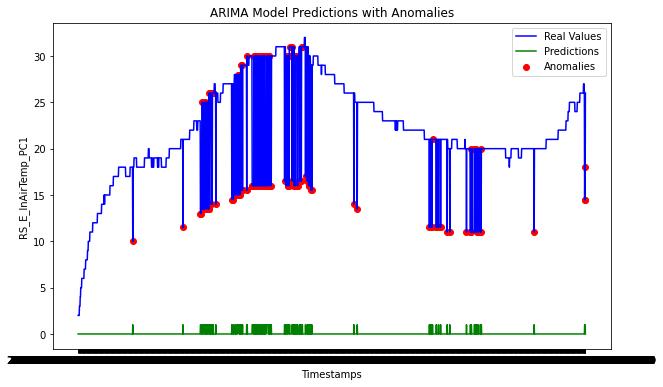

In [51]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(traj1['timestamps_UTC'], traj1['RS_E_InAirTemp_PC1'], label='Real Values', color='blue')
plt.plot(traj1['timestamps_UTC'], predictions, label='Predictions', color='green')
plt.scatter(traj1['timestamps_UTC'][predictions == 1], traj1['RS_E_InAirTemp_PC1'][predictions == 1], label='Anomalies', color='red')
plt.xlabel('Timestamps')
plt.ylabel('RS_E_InAirTemp_PC1')
plt.title('ARIMA Model Predictions with Anomalies')
plt.legend()
plt.show()